In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

In [3]:
def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))


def errAdd(err1, err2):
    """Add error quadral..."""
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))


def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc


def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag


def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None

# Prepare the catalogs of 1-D SBPs

## 2016-02-11

In [4]:
newDir = '/Users/songhuang/work/hscs/gama_massive/sbp/'

bcgFile = 'redbcg_mass_use_sbpsum_modC_muI_imgSub.fits'
memFile = 'redmem_mass_sbpsum_modC_muI1_imgsub.fits'
gamaFile = 'gama_mass_1602_sbpsum_modC_muI1_imgSub.fits'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab
    
# Folder for 3 datasets
bcgDir = os.path.join(newDir, 'redbcg')
memDir = os.path.join(newDir, 'redmem')
gamaDir = os.path.join(newDir, 'gama')

# Two summary catalogs
bcgCat = os.path.join(bcgDir, bcgFile)
memCat = os.path.join(memDir, memFile)
gamaCat = os.path.join(gamaDir, gamaFile)

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gamaCat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gamaCat)
else: 
    gamaTab = Table.read(gamaCat, format='fits')
    
print("## Deal with %i galaxies in redBCH sample" % len(bcgTab))
print("## Deal with %i galaxies in redMEM sample" % len(memTab))
print("## Deal with %i galaxies in GAMA sample" % len(gamaTab))

## Deal with 219 galaxies in redBCH sample
## Deal with 1542 galaxies in redMEM sample
## Deal with 11053 galaxies in GAMA sample


In [5]:
print(bcgTab.colnames)

['ID_CLUSTER_1', 'ID_USE', 'NAME', 'RA_BCG', 'DEC_BCG', 'Z_LAMBDA', 'Z_LAMBDA_ERR', 'LAMBDA_CLUSTER', 'LAMBDA_ERR_CLUSTER', 'S_CLUSTER', 'Z_SPEC_BCG', 'OBJID_BCG', 'IMAG_BCG', 'IMAG_ERR_BCG', 'MODEL_MAG_u_BCG', 'MODEL_MAG_g_BCG', 'MODEL_MAG_r_BCG', 'MODEL_MAG_i_BCG', 'MODEL_MAG_z_BCG', 'MODEL_MAGERR_u_BCG', 'MODEL_MAGERR_g_BCG', 'MODEL_MAGERR_r_BCG', 'MODEL_MAGERR_i_BCG', 'MODEL_MAGERR_z_BCG', 'ILUM_BCG', 'PZBINS_1', 'PZBINS_2', 'PZBINS_3', 'PZ_1', 'PZ_2', 'PZ_3', 'P_CEN_1', 'P_CEN_2', 'P_CEN_3', 'P_CEN_4', 'P_CEN_5', 'RA_CEN_1', 'RA_CEN_2', 'RA_CEN_3', 'RA_CEN_4', 'RA_CEN_5', 'DEC_CEN_1', 'DEC_CEN_2', 'DEC_CEN_3', 'DEC_CEN_4', 'DEC_CEN_5', 'ID_CEN_1', 'ID_CEN_2', 'ID_CEN_3', 'ID_CEN_4', 'ID_CEN_5', 'ra2000', 'decl2000', 'tract', 'patch', 'id', 'parent', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'gmag_psf', 'gmag_psf_err', 'rmag_psf', 'rmag_psf_err', 'imag_psf', 'imag_psf_err', 'zmag_psf', 'zmag_psf_err', 'ymag_psf', 'ymag_psf_err', 'gmag_kron', 'gmag_kron_err', 'rmag_kron', 'rmag_kron_err', 

# Estimate the luminosity, mass-to-light ratio, and stellar mass 

    - Consider the the K-correction 
    - Consider the differen mass models
    
###################################################################################################################
## BCG
###################################################################################################################

* New catalog has been saved !

In [6]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""

# Get absolute magnitude
amagG_bcg = getLuminosity(bcgTab['gmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_g'])
amagR_bcg = getLuminosity(bcgTab['rmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_r'])
amagI_bcg = getLuminosity(bcgTab['imag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_i'])
amagZ_bcg = getLuminosity(bcgTab['zmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_z'])
amagY_bcg = getLuminosity(bcgTab['ymag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_y'])

# Get KCorrection
# Model A
bcgTab['KCORRECT_G'] = (amagG_bcg - bcgTab['ABSMAG_G'])
bcgTab['KCORRECT_R'] = (amagR_bcg - bcgTab['ABSMAG_R'])
bcgTab['KCORRECT_I'] = (amagI_bcg - bcgTab['ABSMAG_I'])
bcgTab['KCORRECT_Z'] = (amagZ_bcg - bcgTab['ABSMAG_Z'])
bcgTab['KCORRECT_Y'] = (amagY_bcg - bcgTab['ABSMAG_Y'])

# Model B
bcgTab['KCORRECT_b_G'] = (amagG_bcg - bcgTab['ABSMAG_b_G'])
bcgTab['KCORRECT_b_R'] = (amagR_bcg - bcgTab['ABSMAG_b_R'])
bcgTab['KCORRECT_b_I'] = (amagI_bcg - bcgTab['ABSMAG_b_I'])
bcgTab['KCORRECT_b_Z'] = (amagZ_bcg - bcgTab['ABSMAG_b_Z'])
bcgTab['KCORRECT_b_Y'] = (amagY_bcg - bcgTab['ABSMAG_b_Y'])

# Model C
bcgTab['KCORRECT_c_G'] = (amagG_bcg - bcgTab['ABSMAG_c_G'])
bcgTab['KCORRECT_c_R'] = (amagR_bcg - bcgTab['ABSMAG_c_R'])
bcgTab['KCORRECT_c_I'] = (amagI_bcg - bcgTab['ABSMAG_c_I'])
bcgTab['KCORRECT_c_Z'] = (amagZ_bcg - bcgTab['ABSMAG_c_Z'])
bcgTab['KCORRECT_c_Y'] = (amagY_bcg - bcgTab['ABSMAG_c_Y'])

In [7]:
## BCG 

## Luminosity based on hscPipe cModel: 
lumI_bcg = getLuminosity(bcgTab['imag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_bcg = getLuminosity(bcgTab['gmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_bcg = getLuminosity(bcgTab['rmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_bcg = getLuminosity(bcgTab['zmag_cmodel'], bcgTab['z_use'], extinction=bcgTab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_bcg = lumI_bcg + (bcgTab['KCORRECT_I'] / 2.5)
lumI_kB_bcg = lumI_bcg + (bcgTab['KCORRECT_b_I'] / 2.5)
lumI_kC_bcg = lumI_bcg + (bcgTab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_R'])
gi_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_I']) 
gz_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_Z'])
ri_kA_bcg = (bcgTab['ABSMAG_R'] - bcgTab['ABSMAG_I'])
### Model B
gr_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_R'])
gi_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_I']) 
gz_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_Z'])
ri_kB_bcg = (bcgTab['ABSMAG_b_R'] - bcgTab['ABSMAG_b_I'])
### Model C
gr_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_R'])
gi_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_I']) 
gz_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_Z'])
ri_kC_bcg = (bcgTab['ABSMAG_c_R'] - bcgTab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_bcg = (bcgTab['MSTAR'] - lumI_bcg)
logm2lI_B_bcg = (bcgTab['MSTAR_b'] - lumI_bcg)
logm2lI_C_bcg = (bcgTab['MSTAR_c'] - lumI_bcg)

In [8]:
bcgTab.add_column(Column(name='lumI_cmodel', data=lumI_bcg))
bcgTab.add_column(Column(name='lumG_cmodel', data=lumG_bcg))
bcgTab.add_column(Column(name='lumR_cmodel', data=lumR_bcg))
bcgTab.add_column(Column(name='lumZ_cmodel', data=lumZ_bcg))

bcgTab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_bcg))
bcgTab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_bcg))
bcgTab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_bcg))

bcgTab.add_column(Column(name='gr_kA', data=gr_kA_bcg))
bcgTab.add_column(Column(name='gi_kA', data=gi_kA_bcg))
bcgTab.add_column(Column(name='gz_kA', data=gz_kA_bcg))
bcgTab.add_column(Column(name='ri_kA', data=ri_kA_bcg))
bcgTab.add_column(Column(name='gr_kB', data=gr_kB_bcg))
bcgTab.add_column(Column(name='gi_kB', data=gi_kB_bcg))
bcgTab.add_column(Column(name='gz_kB', data=gz_kB_bcg))
bcgTab.add_column(Column(name='ri_kB', data=ri_kB_bcg))
bcgTab.add_column(Column(name='gr_kC', data=gr_kC_bcg))
bcgTab.add_column(Column(name='gi_kC', data=gi_kC_bcg))
bcgTab.add_column(Column(name='gz_kC', data=gz_kC_bcg))
bcgTab.add_column(Column(name='ri_kC', data=ri_kC_bcg))

bcgTab.add_column(Column(name='logm2lI_A', data=logm2lI_A_bcg))
bcgTab.add_column(Column(name='logm2lI_B', data=logm2lI_B_bcg))
bcgTab.add_column(Column(name='logm2lI_C', data=logm2lI_C_bcg))

In [9]:
# Stellar mass based on 1-D profiles
try:
    ## Use lum 5
    bcgTab.add_column(Column(name='m5_c', 
                             data=(bcgTab['lum_5'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m5_a', 
                             data=(bcgTab['lum_5'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m5_b', 
                             data=(bcgTab['lum_5'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 15
    bcgTab.add_column(Column(name='m15_c', 
                             data=(bcgTab['lum_15'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m15_a', 
                             data=(bcgTab['lum_15'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m15_b', 
                             data=(bcgTab['lum_15'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 30
    bcgTab.add_column(Column(name='m30_c', 
                             data=(bcgTab['lum_30'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m30_a', 
                             data=(bcgTab['lum_30'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m30_b', 
                             data=(bcgTab['lum_30'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 40
    bcgTab.add_column(Column(name='m40_c', 
                             data=(bcgTab['lum_40'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m40_a', 
                             data=(bcgTab['lum_40'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m40_b', 
                             data=(bcgTab['lum_40'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 50
    bcgTab.add_column(Column(name='m50_c', 
                             data=(bcgTab['lum_50'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m50_a', 
                             data=(bcgTab['lum_50'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m50_b', 
                             data=(bcgTab['lum_50'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 60
    bcgTab.add_column(Column(name='m60_c', 
                             data=(bcgTab['lum_60'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m60_a', 
                             data=(bcgTab['lum_60'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m60_b', 
                             data=(bcgTab['lum_60'] + bcgTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 75
    bcgTab.add_column(Column(name='m75_c', 
                             data=(bcgTab['lum_75'] + bcgTab['logm2lI_C'])))
    bcgTab.add_column(Column(name='m75_a', 
                             data=(bcgTab['lum_75'] + bcgTab['logm2lI_A'])))
    bcgTab.add_column(Column(name='m75_b', 
                             data=(bcgTab['lum_75'] + bcgTab['logm2lI_B'])))
except Exception:
    pass


## Use lum 10
bcgTab.add_column(Column(name='m10_c', 
                         data=(bcgTab['lum_10'] + bcgTab['logm2lI_C'])))
bcgTab.add_column(Column(name='m10_a', 
                         data=(bcgTab['lum_10'] + bcgTab['logm2lI_A'])))
bcgTab.add_column(Column(name='m10_b', 
                         data=(bcgTab['lum_10'] + bcgTab['logm2lI_B'])))

## Use lum 100
bcgTab.add_column(Column(name='m100_c', 
                         data=(bcgTab['lum_100'] + bcgTab['logm2lI_C'])))
bcgTab.add_column(Column(name='m100_a', 
                         data=(bcgTab['lum_100'] + bcgTab['logm2lI_A'])))
bcgTab.add_column(Column(name='m100_b', 
                         data=(bcgTab['lum_100'] + bcgTab['logm2lI_B'])))

## Use lum 120
bcgTab.add_column(Column(name='m120_c', 
                         data=(bcgTab['lum_120'] + bcgTab['logm2lI_C'])))
bcgTab.add_column(Column(name='m120_a', 
                         data=(bcgTab['lum_120'] + bcgTab['logm2lI_A'])))
bcgTab.add_column(Column(name='m120_b', 
                         data=(bcgTab['lum_120'] + bcgTab['logm2lI_B'])))

## Use lum 150
bcgTab.add_column(Column(name='m150_c', 
                         data=(bcgTab['lum_150'] + bcgTab['logm2lI_C'])))
bcgTab.add_column(Column(name='m150_a', 
                         data=(bcgTab['lum_150'] + bcgTab['logm2lI_A'])))
bcgTab.add_column(Column(name='m150_b', 
                         data=(bcgTab['lum_150'] + bcgTab['logm2lI_B'])))

## Use lum max
bcgTab.add_column(Column(name='mmax_c', 
                         data=(bcgTab['lum_max'] + bcgTab['logm2lI_C'])))
bcgTab.add_column(Column(name='mmax_a', 
                         data=(bcgTab['lum_max'] + bcgTab['logm2lI_A'])))
bcgTab.add_column(Column(name='mmax_b', 
                         data=(bcgTab['lum_max'] + bcgTab['logm2lI_B'])))

In [10]:
# Update the redBCG catalog: 

bcgTab.write(os.path.join(newDir, 'redbcg_1d_160211.fits'), overwrite=True)

###################################################################################################################
## Cluster Member 
###################################################################################################################

* New catalog has been saved !

In [12]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_mem = getLuminosity(memTab['gmag_cmodel'], memTab['Z'], extinction=memTab['a_g'])
amagR_mem = getLuminosity(memTab['rmag_cmodel'], memTab['Z'], extinction=memTab['a_r'])
amagI_mem = getLuminosity(memTab['imag_cmodel'], memTab['Z'], extinction=memTab['a_i'])
amagZ_mem = getLuminosity(memTab['zmag_cmodel'], memTab['Z'], extinction=memTab['a_z'])
amagY_mem = getLuminosity(memTab['ymag_cmodel'], memTab['Z'], extinction=memTab['a_y'])

# Model A
memTab['KCORRECT_G'] = (amagG_mem - memTab['ABSMAG_G'])
memTab['KCORRECT_R'] = (amagR_mem - memTab['ABSMAG_R'])
memTab['KCORRECT_I'] = (amagI_mem - memTab['ABSMAG_I'])
memTab['KCORRECT_Z'] = (amagZ_mem - memTab['ABSMAG_Z'])
memTab['KCORRECT_Y'] = (amagY_mem - memTab['ABSMAG_Y'])

# Model B
memTab['KCORRECT_b_G'] = (amagG_mem - memTab['ABSMAG_b_G'])
memTab['KCORRECT_b_R'] = (amagR_mem - memTab['ABSMAG_b_R'])
memTab['KCORRECT_b_I'] = (amagI_mem - memTab['ABSMAG_b_I'])
memTab['KCORRECT_b_Z'] = (amagZ_mem - memTab['ABSMAG_b_Z'])
memTab['KCORRECT_b_Y'] = (amagY_mem - memTab['ABSMAG_b_Y'])

# Model C
memTab['KCORRECT_c_G'] = (amagG_mem - memTab['ABSMAG_c_G'])
memTab['KCORRECT_c_R'] = (amagR_mem - memTab['ABSMAG_c_R'])
memTab['KCORRECT_c_I'] = (amagI_mem - memTab['ABSMAG_c_I'])
memTab['KCORRECT_c_Z'] = (amagZ_mem - memTab['ABSMAG_c_Z'])
memTab['KCORRECT_c_Y'] = (amagY_mem - memTab['ABSMAG_c_Y'])

In [13]:
## Mem

## Luminosity based on hscPipe cModel: 
lumI_mem = getLuminosity(memTab['imag_cmodel'], memTab['Z'], extinction=memTab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_mem = getLuminosity(memTab['gmag_cmodel'], memTab['Z'], extinction=memTab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_mem = getLuminosity(memTab['rmag_cmodel'], memTab['Z'], extinction=memTab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_mem = getLuminosity(memTab['zmag_cmodel'], memTab['Z'], extinction=memTab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_mem = lumI_mem + (memTab['KCORRECT_I'] / 2.5)
lumI_kB_mem = lumI_mem + (memTab['KCORRECT_b_I'] / 2.5)
lumI_kC_mem = lumI_mem + (memTab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_R'])
gi_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_I']) 
gz_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_Z'])
ri_kA_mem = (memTab['ABSMAG_R'] - memTab['ABSMAG_I'])
### Model B
gr_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_R'])
gi_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_I']) 
gz_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_Z'])
ri_kB_mem = (memTab['ABSMAG_b_R'] - memTab['ABSMAG_b_I'])
### Model C
gr_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_R'])
gi_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_I']) 
gz_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_Z'])
ri_kC_mem = (memTab['ABSMAG_c_R'] - memTab['ABSMAG_c_I'])

## Stellar mass from iSEDFit 
logm2lI_A_mem = (memTab['MSTAR'] - lumI_mem)
logm2lI_B_mem = (memTab['MSTAR_b'] - lumI_mem)
logm2lI_C_mem = (memTab['MSTAR_c'] - lumI_mem)

In [14]:
memTab.add_column(Column(name='lumI_cmodel', data=lumI_mem))
memTab.add_column(Column(name='lumG_cmodel', data=lumG_mem))
memTab.add_column(Column(name='lumR_cmodel', data=lumR_mem))
memTab.add_column(Column(name='lumZ_cmodel', data=lumZ_mem))

memTab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_mem))
memTab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_mem))
memTab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_mem))

memTab.add_column(Column(name='gr_kA', data=gr_kA_mem))
memTab.add_column(Column(name='gi_kA', data=gi_kA_mem))
memTab.add_column(Column(name='gz_kA', data=gz_kA_mem))
memTab.add_column(Column(name='ri_kA', data=ri_kA_mem))
memTab.add_column(Column(name='gr_kB', data=gr_kB_mem))
memTab.add_column(Column(name='gi_kB', data=gi_kB_mem))
memTab.add_column(Column(name='gz_kB', data=gz_kB_mem))
memTab.add_column(Column(name='ri_kB', data=ri_kB_mem))
memTab.add_column(Column(name='gr_kC', data=gr_kC_mem))
memTab.add_column(Column(name='gi_kC', data=gi_kC_mem))
memTab.add_column(Column(name='gz_kC', data=gz_kC_mem))
memTab.add_column(Column(name='ri_kC', data=ri_kC_mem))
memTab.add_column(Column(name='logm2lI_A', data=logm2lI_A_mem))
memTab.add_column(Column(name='logm2lI_B', data=logm2lI_B_mem))
memTab.add_column(Column(name='logm2lI_C', data=logm2lI_C_mem))

In [15]:
# Stellar mass based on 1-D profiles

try:
    ## Use lum 5
    memTab.add_column(Column(name='m5_c', 
                             data=(memTab['lum_5'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m5_a', 
                             data=(memTab['lum_5'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m5_b', 
                             data=(memTab['lum_5'] + memTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 15
    memTab.add_column(Column(name='m15_c', 
                             data=(memTab['lum_15'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m15_a', 
                             data=(memTab['lum_15'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m15_b', 
                             data=(memTab['lum_15'] + memTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 30
    memTab.add_column(Column(name='m30_c', 
                             data=(memTab['lum_30'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m30_a', 
                             data=(memTab['lum_30'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m30_b', 
                             data=(memTab['lum_30'] + memTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 40
    memTab.add_column(Column(name='m40_c', 
                             data=(memTab['lum_40'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m40_a', 
                             data=(memTab['lum_40'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m40_b', 
                             data=(memTab['lum_40'] + memTab['logm2lI_B'])))
except Exception:
    pass


try:
    ## Use lum 50
    memTab.add_column(Column(name='m50_c', 
                             data=(memTab['lum_50'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m50_a', 
                             data=(memTab['lum_50'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m50_b', 
                             data=(memTab['lum_50'] + memTab['logm2lI_B'])))
except Exception:
    pass


try:
    ## Use lum 60
    memTab.add_column(Column(name='m60_c', 
                             data=(memTab['lum_60'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m60_a', 
                             data=(memTab['lum_60'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m60_b', 
                             data=(memTab['lum_60'] + memTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 75
    memTab.add_column(Column(name='m75_c', 
                             data=(memTab['lum_75'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m75_a', 
                             data=(memTab['lum_75'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m75_b', 
                             data=(memTab['lum_75'] + memTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 150
    memTab.add_column(Column(name='m150_c', 
                             data=(memTab['lum_150'] + memTab['logm2lI_C'])))
    memTab.add_column(Column(name='m150_a', 
                             data=(memTab['lum_150'] + memTab['logm2lI_A'])))
    memTab.add_column(Column(name='m150_b', 
                             data=(memTab['lum_150'] + memTab['logm2lI_B'])))
except Exception:
    pass

## Use lum 10
memTab.add_column(Column(name='m10_c', 
                         data=(memTab['lum_10'] + memTab['logm2lI_C'])))
memTab.add_column(Column(name='m10_a', 
                         data=(memTab['lum_10'] + memTab['logm2lI_A'])))
memTab.add_column(Column(name='m10_b', 
                         data=(memTab['lum_10'] + memTab['logm2lI_B'])))

## Use lum 100
memTab.add_column(Column(name='m100_c', 
                         data=(memTab['lum_100'] + memTab['logm2lI_C'])))
memTab.add_column(Column(name='m100_a', 
                         data=(memTab['lum_100'] + memTab['logm2lI_A'])))
memTab.add_column(Column(name='m100_b', 
                         data=(memTab['lum_100'] + memTab['logm2lI_B'])))
## Use lum 120
memTab.add_column(Column(name='m120_c', 
                         data=(memTab['lum_120'] + memTab['logm2lI_C'])))
memTab.add_column(Column(name='m120_a', 
                         data=(memTab['lum_120'] + memTab['logm2lI_A'])))
memTab.add_column(Column(name='m120_b', 
                         data=(memTab['lum_120'] + memTab['logm2lI_B'])))

## Use lum max
memTab.add_column(Column(name='mmax_c', 
                         data=(memTab['lum_max'] + memTab['logm2lI_C'])))
memTab.add_column(Column(name='mmax_a', 
                         data=(memTab['lum_max'] + memTab['logm2lI_A'])))
memTab.add_column(Column(name='mmax_b', 
                         data=(memTab['lum_max'] + memTab['logm2lI_B'])))

In [16]:
# Update the redMEM catalog: 

memTab.write(os.path.join(newDir, 'redmem_1d_160211.fits'), overwrite=True)

###################################################################################################################
## GAMA
###################################################################################################################

* New catalog has been saved !

In [17]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_gama = getLuminosity(gamaTab['gmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_g'])
amagR_gama = getLuminosity(gamaTab['rmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_r'])
amagI_gama = getLuminosity(gamaTab['imag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_i'])
amagZ_gama = getLuminosity(gamaTab['zmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_z'])
amagY_gama = getLuminosity(gamaTab['ymag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_y'])

# Model A
gamaTab['KCORRECT_G'] = (amagG_gama - gamaTab['ABSMAG_G'])
gamaTab['KCORRECT_R'] = (amagR_gama - gamaTab['ABSMAG_R'])
gamaTab['KCORRECT_I'] = (amagI_gama - gamaTab['ABSMAG_I'])
gamaTab['KCORRECT_Z'] = (amagZ_gama - gamaTab['ABSMAG_Z'])
gamaTab['KCORRECT_Y'] = (amagY_gama - gamaTab['ABSMAG_Y'])

# Model B
gamaTab['KCORRECT_b_G'] = (amagG_gama - gamaTab['ABSMAG_b_G'])
gamaTab['KCORRECT_b_R'] = (amagR_gama - gamaTab['ABSMAG_b_R'])
gamaTab['KCORRECT_b_I'] = (amagI_gama - gamaTab['ABSMAG_b_I'])
gamaTab['KCORRECT_b_Z'] = (amagZ_gama - gamaTab['ABSMAG_b_Z'])
gamaTab['KCORRECT_b_Y'] = (amagY_gama - gamaTab['ABSMAG_b_Y'])

# Model C
gamaTab['KCORRECT_c_G'] = (amagG_gama - gamaTab['ABSMAG_c_G'])
gamaTab['KCORRECT_c_R'] = (amagR_gama - gamaTab['ABSMAG_c_R'])
gamaTab['KCORRECT_c_I'] = (amagI_gama - gamaTab['ABSMAG_c_I'])
gamaTab['KCORRECT_c_Z'] = (amagZ_gama - gamaTab['ABSMAG_c_Z'])
gamaTab['KCORRECT_c_Y'] = (amagY_gama - gamaTab['ABSMAG_c_Y'])

In [18]:
## GAMA

## Luminosity based on hscPipe cModel: 
lumI_gama = getLuminosity(gamaTab['imag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_gama = getLuminosity(gamaTab['gmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_gama = getLuminosity(gamaTab['rmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_gama = getLuminosity(gamaTab['zmag_cmodel'], gamaTab['Z'], extinction=gamaTab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_gama = lumI_gama + (gamaTab['KCORRECT_I'] / 2.5)
lumI_kB_gama = lumI_gama + (gamaTab['KCORRECT_b_I'] / 2.5)
lumI_kC_gama = lumI_gama + (gamaTab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_gama = (gamaTab['ABSMAG_G'] - gamaTab['ABSMAG_R'])
gi_kA_gama = (gamaTab['ABSMAG_G'] - gamaTab['ABSMAG_I']) 
gz_kA_gama = (gamaTab['ABSMAG_G'] - gamaTab['ABSMAG_Z'])
ri_kA_gama = (gamaTab['ABSMAG_R'] - gamaTab['ABSMAG_I'])
### Model B
gr_kB_gama = (gamaTab['ABSMAG_b_G'] - gamaTab['ABSMAG_b_R'])
gi_kB_gama = (gamaTab['ABSMAG_b_G'] - gamaTab['ABSMAG_b_I']) 
gz_kB_gama = (gamaTab['ABSMAG_b_G'] - gamaTab['ABSMAG_b_Z'])
ri_kB_gama = (gamaTab['ABSMAG_b_R'] - gamaTab['ABSMAG_b_I'])
### Model C
gr_kC_gama = (gamaTab['ABSMAG_c_G'] - gamaTab['ABSMAG_c_R'])
gi_kC_gama = (gamaTab['ABSMAG_c_G'] - gamaTab['ABSMAG_c_I']) 
gz_kC_gama = (gamaTab['ABSMAG_c_G'] - gamaTab['ABSMAG_c_Z'])
ri_kC_gama = (gamaTab['ABSMAG_c_R'] - gamaTab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_gama = (gamaTab['MSTAR'] - lumI_gama)
logm2lI_B_gama = (gamaTab['MSTAR_b'] - lumI_gama)
logm2lI_C_gama = (gamaTab['MSTAR_c'] - lumI_gama)

In [19]:
gamaTab.add_column(Column(name='lumI_cmodel', data=lumI_gama))
gamaTab.add_column(Column(name='lumG_cmodel', data=lumG_gama))
gamaTab.add_column(Column(name='lumR_cmodel', data=lumR_gama))
gamaTab.add_column(Column(name='lumZ_cmodel', data=lumZ_gama))

gamaTab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_gama))
gamaTab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_gama))
gamaTab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_gama))

gamaTab.add_column(Column(name='gr_kA', data=gr_kA_gama))
gamaTab.add_column(Column(name='gi_kA', data=gi_kA_gama))
gamaTab.add_column(Column(name='gz_kA', data=gz_kA_gama))
gamaTab.add_column(Column(name='ri_kA', data=ri_kA_gama))
gamaTab.add_column(Column(name='gr_kB', data=gr_kB_gama))
gamaTab.add_column(Column(name='gi_kB', data=gi_kB_gama))
gamaTab.add_column(Column(name='gz_kB', data=gz_kB_gama))
gamaTab.add_column(Column(name='ri_kB', data=ri_kB_gama))
gamaTab.add_column(Column(name='gr_kC', data=gr_kC_gama))
gamaTab.add_column(Column(name='gi_kC', data=gi_kC_gama))
gamaTab.add_column(Column(name='gz_kC', data=gz_kC_gama))
gamaTab.add_column(Column(name='ri_kC', data=ri_kC_gama))

gamaTab.add_column(Column(name='logm2lI_A', data=logm2lI_A_gama))
gamaTab.add_column(Column(name='logm2lI_B', data=logm2lI_B_gama))
gamaTab.add_column(Column(name='logm2lI_C', data=logm2lI_C_gama))

In [20]:
# Stellar mass based on 1-D profiles

try:
    ## Use lum 5
    gamaTab.add_column(Column(name='m5_c', 
                              data=(gamaTab['lum_5'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m5_a', 
                              data=(gamaTab['lum_5'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m5_b', 
                              data=(gamaTab['lum_5'] + gamaTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 15
    gamaTab.add_column(Column(name='m15_c', 
                              data=(gamaTab['lum_15'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m15_a', 
                              data=(gamaTab['lum_15'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m15_b', 
                              data=(gamaTab['lum_15'] + gamaTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 30
    gamaTab.add_column(Column(name='m30_c', 
                              data=(gamaTab['lum_30'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m30_a', 
                              data=(gamaTab['lum_30'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m30_b', 
                              data=(gamaTab['lum_30'] + gamaTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 40
    gamaTab.add_column(Column(name='m40_c', 
                              data=(gamaTab['lum_40'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m40_a', 
                              data=(gamaTab['lum_40'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m40_b', 
                              data=(gamaTab['lum_40'] + gamaTab['logm2lI_B'])))
except Exception:
    pass


try:
    ## Use lum 50
    gamaTab.add_column(Column(name='m50_c', 
                              data=(gamaTab['lum_50'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m50_a', 
                              data=(gamaTab['lum_50'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m50_b', 
                              data=(gamaTab['lum_50'] + gamaTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 60
    gamaTab.add_column(Column(name='m60_c', 
                              data=(gamaTab['lum_60'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m60_a', 
                              data=(gamaTab['lum_60'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m60_b', 
                              data=(gamaTab['lum_60'] + gamaTab['logm2lI_B'])))
except Exception:
    pass

try:
    ## Use lum 75
    gamaTab.add_column(Column(name='m75_c', 
                              data=(gamaTab['lum_75'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m75_a', 
                              data=(gamaTab['lum_75'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m75_b', 
                              data=(gamaTab['lum_75'] + gamaTab['logm2lI_B'])))
except Exception:
    pass


try:
    ## Use lum 150
    gamaTab.add_column(Column(name='m150_c', 
                              data=(gamaTab['lum_150'] + gamaTab['logm2lI_C'])))
    gamaTab.add_column(Column(name='m150_a', 
                              data=(gamaTab['lum_150'] + gamaTab['logm2lI_A'])))
    gamaTab.add_column(Column(name='m150_b', 
                              data=(gamaTab['lum_150'] + gamaTab['logm2lI_B'])))
except Exception:
    pass


## Use lum 10
gamaTab.add_column(Column(name='m10_c', 
                          data=(gamaTab['lum_10'] + gamaTab['logm2lI_C'])))
gamaTab.add_column(Column(name='m10_a', 
                          data=(gamaTab['lum_10'] + gamaTab['logm2lI_A'])))
gamaTab.add_column(Column(name='m10_b', 
                          data=(gamaTab['lum_10'] + gamaTab['logm2lI_B'])))

## Use lum 100
gamaTab.add_column(Column(name='m100_c', 
                          data=(gamaTab['lum_100'] + gamaTab['logm2lI_C'])))
gamaTab.add_column(Column(name='m100_a', 
                          data=(gamaTab['lum_100'] + gamaTab['logm2lI_A'])))
gamaTab.add_column(Column(name='m100_b', 
                          data=(gamaTab['lum_100'] + gamaTab['logm2lI_B'])))
## Use lum 120
gamaTab.add_column(Column(name='m120_c', 
                          data=(gamaTab['lum_120'] + gamaTab['logm2lI_C'])))
gamaTab.add_column(Column(name='m120_a', 
                          data=(gamaTab['lum_120'] + gamaTab['logm2lI_A'])))
gamaTab.add_column(Column(name='m120_b', 
                          data=(gamaTab['lum_120'] + gamaTab['logm2lI_B'])))

## Use lum max
gamaTab.add_column(Column(name='mmax_c', 
                          data=(gamaTab['lum_max'] + gamaTab['logm2lI_C'])))
gamaTab.add_column(Column(name='mmax_a', 
                          data=(gamaTab['lum_max'] + gamaTab['logm2lI_A'])))
gamaTab.add_column(Column(name='mmax_b', 
                          data=(gamaTab['lum_max'] + gamaTab['logm2lI_B'])))

In [21]:
# Update the redMEM catalog: 

gamaTab.write(os.path.join(newDir, 'gama_1d_160211.fits'), overwrite=True)

# Show the K-Correction

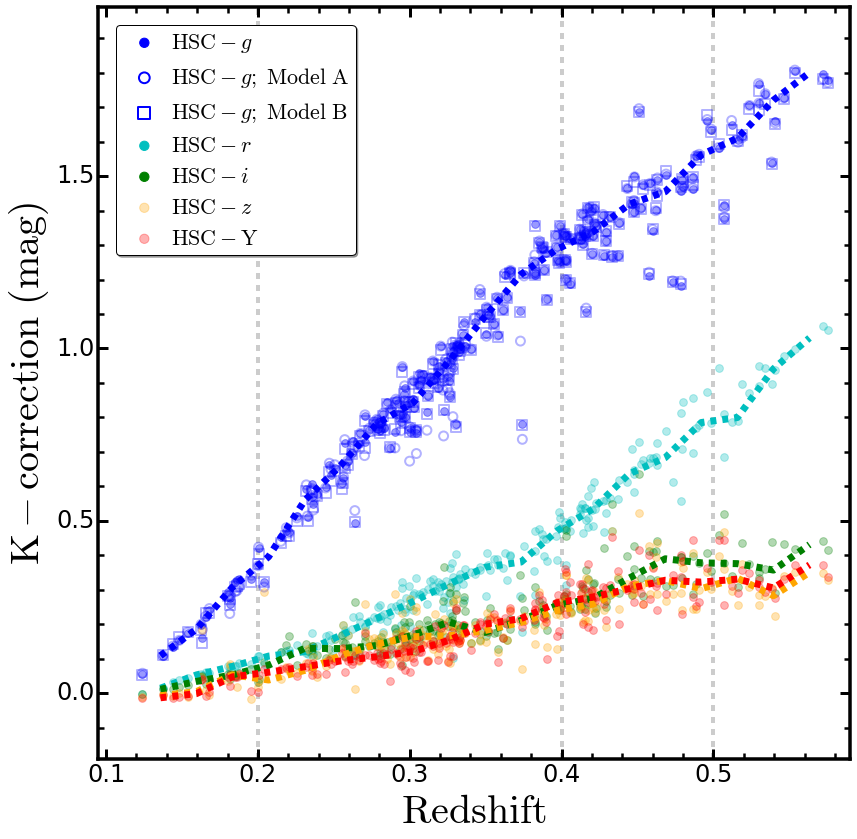

In [79]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_G'] + 0.1, c='b', 
            marker='o', facecolor='none', edgecolor='b', s=60, 
            alpha=0.4, label='$\mathrm{HSC-}g$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_G'] + 0.1,
            marker='o', facecolor='none', edgecolor='b', s=80, 
            alpha=0.3, label='$\mathrm{HSC-}g\mathrm{;\ Model\ A}$', linewidth=2.0)
ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_b_G'] + 0.1,
            marker='s', facecolor='none', edgecolor='b', s=100, 
            alpha=0.3, label='$\mathrm{HSC-}g\mathrm{;\ Model\ B}$', linewidth=2.0)

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_R'] + 0.1, c='c', 
            marker='o', facecolor='none', edgecolor='c', s=60, 
            alpha=0.3, label='$\mathrm{HSC-}r$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_I'] + 0.1, c='g', 
            marker='o', facecolor='none', edgecolor='g', s=60, 
            alpha=0.3, label='$\mathrm{HSC-}i$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_Z'] + 0.1, c='orange', 
            marker='o', facecolor='none', edgecolor='orange', s=60, 
            alpha=0.3, label='$\mathrm{HSC-}z$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_Y'] + 0.1, c='r', 
            marker='o', facecolor='none', edgecolor='r', s=60, 
            alpha=0.3, label='$\mathrm{HSC-Y}$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.19, 1.99)

ax1.legend(loc=(0.023, 0.67), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)

YY1 = (bcgTab['KCORRECT_c_G'] + 0.1)
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_R'] + 0.1)
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_I'] + 0.1)
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_Z'] + 0.1)
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_Y'] + 0.1)
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_bcg.png', dpi=300)

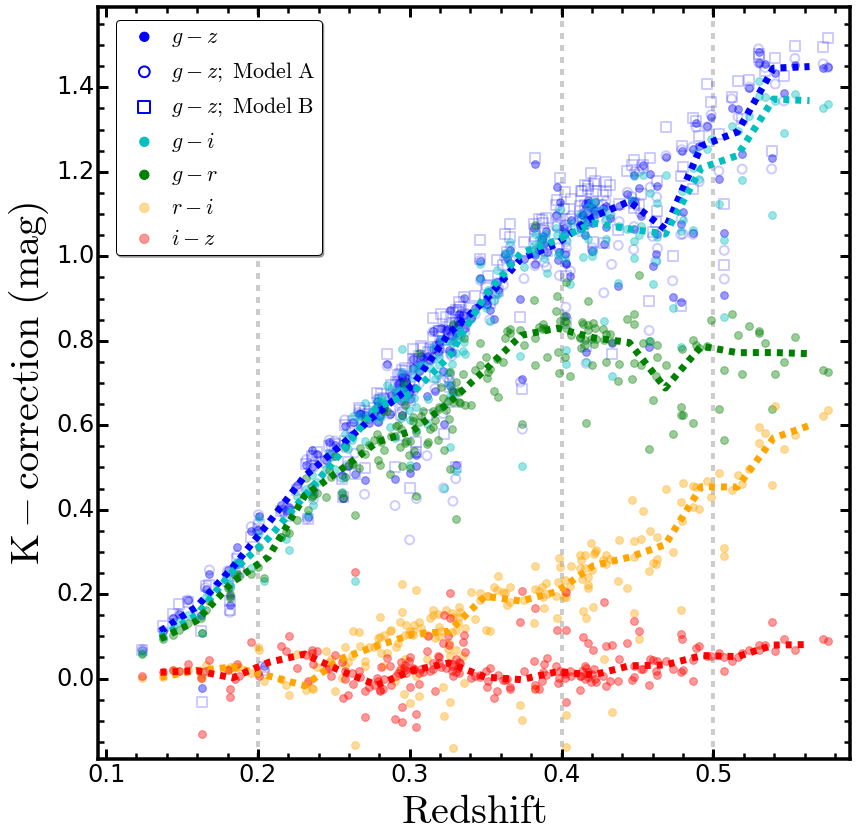

In [80]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_Z'], 
            marker='o', facecolor='b', edgecolor='b', s=60, 
            alpha=0.4, label='$g-z$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_G'] - bcgTab['KCORRECT_Z'],
            marker='o', facecolor='none', edgecolor='b', s=80, 
            alpha=0.2, label='$g-z\mathrm{;\ Model\ A}$', linewidth=2.0)
ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_b_G'] - bcgTab['KCORRECT_b_Z'],
            marker='s', facecolor='none', edgecolor='b', s=100, 
            alpha=0.2, label='$g-z\mathrm{;\ Model\ B}$', linewidth=2.0)

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_I'], 
            marker='o', facecolor='c', edgecolor='c', s=60, 
            alpha=0.4, label='$g-i$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_R'], 
            marker='o', facecolor='g', edgecolor='g', s=60, 
            alpha=0.4, label='$g-r$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_R'] - bcgTab['KCORRECT_c_I'], 
            marker='o', facecolor='orange', edgecolor='orange', s=60, 
            alpha=0.4, label='$r-i$')

ax1.scatter(bcgTab['Z'], bcgTab['KCORRECT_c_I'] - bcgTab['KCORRECT_c_Z'], 
            marker='o', facecolor='r', edgecolor='r', s=60, 
            alpha=0.4, label='$i-z$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.19, 1.59)

ax1.legend(loc=(0.023, 0.67), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)
 
YY1 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_Z'])
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_I'])
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_R'])
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_R'] - bcgTab['KCORRECT_c_I'])
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_I'] - bcgTab['KCORRECT_c_Z'])
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_color_bcg.png', dpi=300)

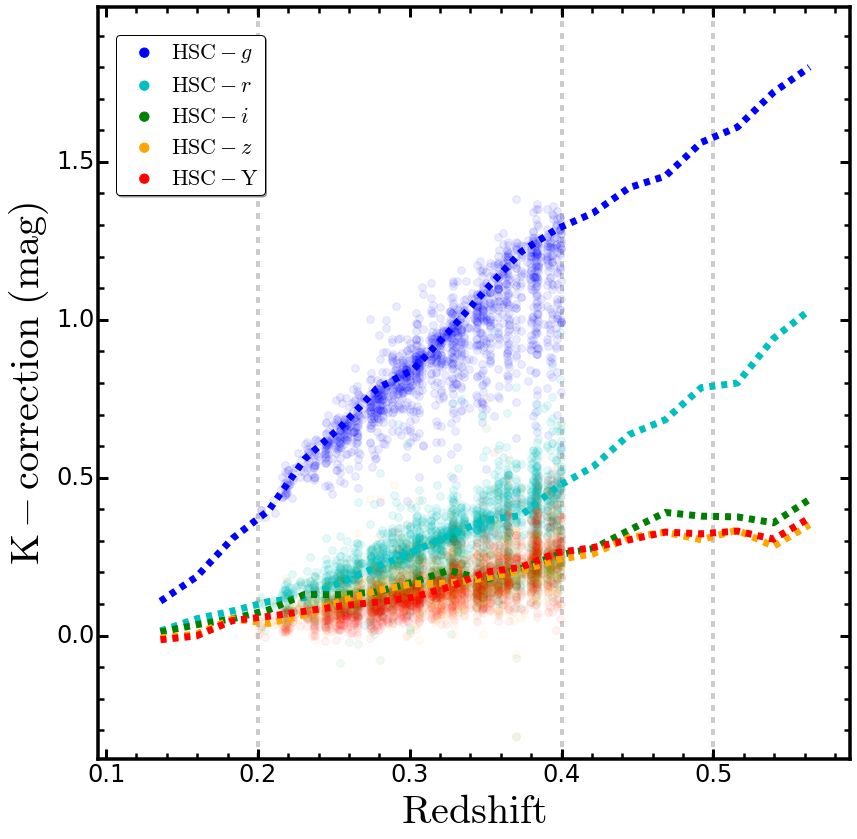

In [81]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(memTab['Z'], memTab['KCORRECT_c_G'] + 0.1, c='b', 
            marker='o', facecolor='none', edgecolor='b', s=60, 
            alpha=0.08, label='$\mathrm{HSC-}g$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_R'] + 0.1, c='c', 
            marker='o', facecolor='none', edgecolor='c', s=60, 
            alpha=0.1, label='$\mathrm{HSC-}r$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_I'] + 0.1, c='g', 
            marker='o', facecolor='none', edgecolor='g', s=60, 
            alpha=0.05, label='$\mathrm{HSC-}i$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_Z'] + 0.1, c='orange', 
            marker='o', facecolor='none', edgecolor='orange', s=60, 
            alpha=0.05, label='$\mathrm{HSC-}z$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_Y'] + 0.1, c='r', 
            marker='o', facecolor='none', edgecolor='r', s=60, 
            alpha=0.05, label='$\mathrm{HSC-Y}$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.39, 1.99)

ax1.legend(loc=(0.023, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)

YY1 = (bcgTab['KCORRECT_c_G'] + 0.1)
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_R'] + 0.1)
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_I'] + 0.1)
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_Z'] + 0.1)
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_Y'] + 0.1)
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_mem.png', dpi=300)

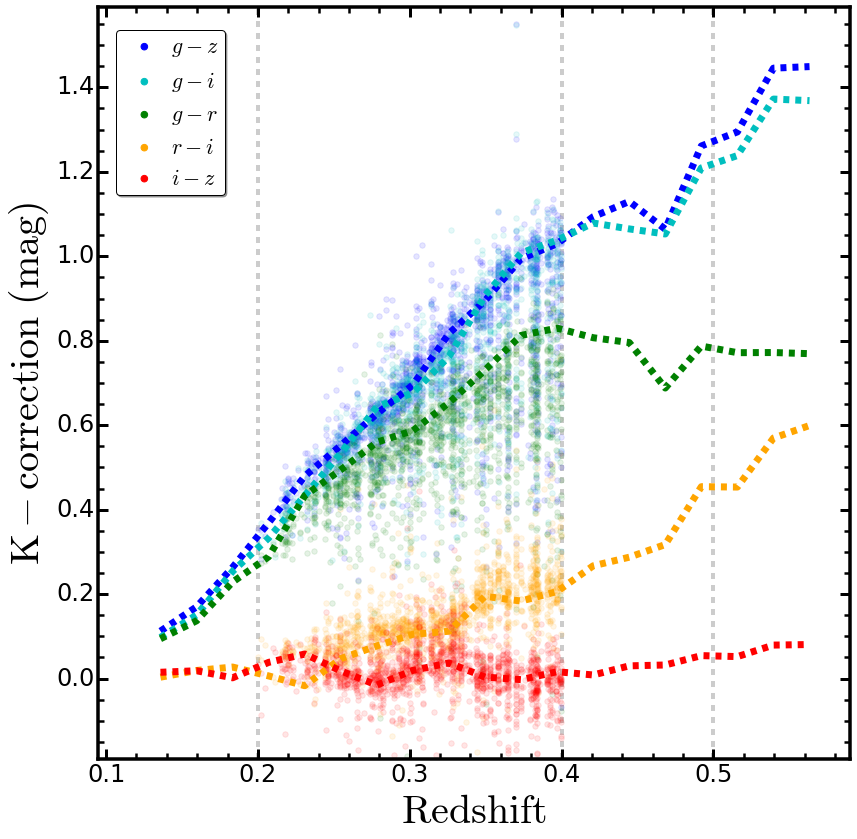

In [83]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(memTab['Z'], memTab['KCORRECT_c_G'] - memTab['KCORRECT_c_Z'], 
            marker='o', facecolor='b', edgecolor='b', s=30, 
            alpha=0.10, label='$g-z$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_G'] - memTab['KCORRECT_c_I'], 
            marker='o', facecolor='c', edgecolor='c', s=30, 
            alpha=0.10, label='$g-i$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_G'] - memTab['KCORRECT_c_R'], 
            marker='o', facecolor='g', edgecolor='g', s=30, 
            alpha=0.10, label='$g-r$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_R'] - memTab['KCORRECT_c_I'], 
            marker='o', facecolor='orange', edgecolor='orange', s=30, 
            alpha=0.10, label='$r-i$')

ax1.scatter(memTab['Z'], memTab['KCORRECT_c_I'] - memTab['KCORRECT_c_Z'], 
            marker='o', facecolor='r', edgecolor='r', s=30, 
            alpha=0.10, label='$i-z$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.19, 1.59)

ax1.legend(loc=(0.023, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)
 
YY1 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_Z'])
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_I'])
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_R'])
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_R'] - bcgTab['KCORRECT_c_I'])
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_I'] - bcgTab['KCORRECT_c_Z'])
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_color_mem.png', dpi=300)

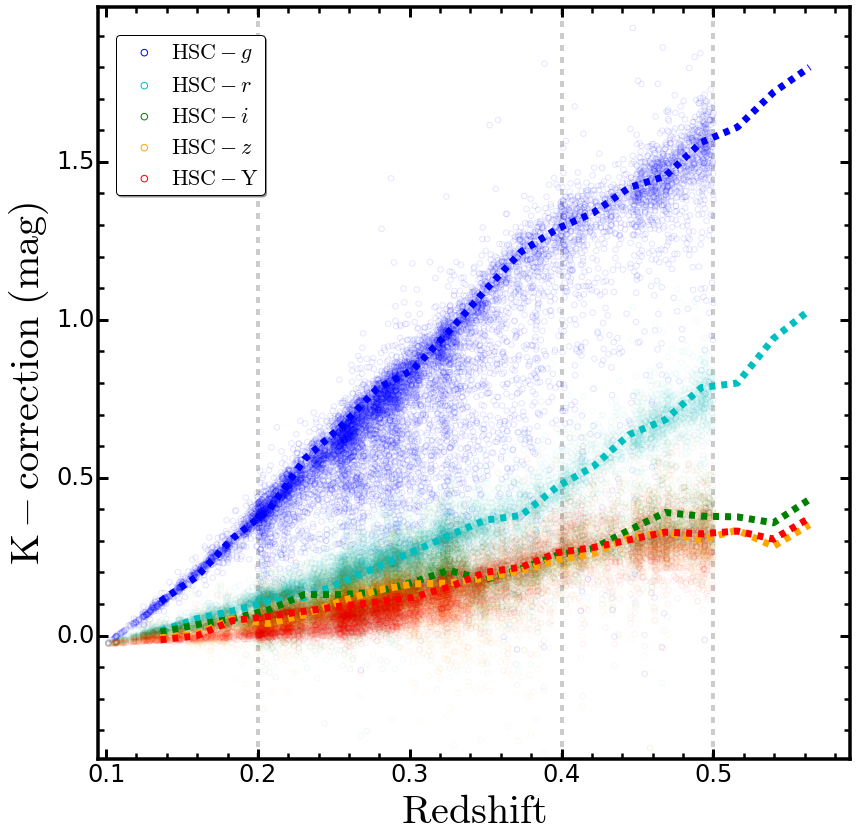

In [84]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_G'] + 0.1, 
            marker='o', facecolor='none', edgecolor='b', s=30, 
            alpha=0.10, label='$\mathrm{HSC-}g$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_R'] + 0.1, 
            marker='o', facecolor='none', edgecolor='c', s=30, 
            alpha=0.05, label='$\mathrm{HSC-}r$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_I'] + 0.1, 
            marker='o', facecolor='none', edgecolor='g', s=30, 
            alpha=0.05, label='$\mathrm{HSC-}i$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_Z'] + 0.1, 
            marker='o', facecolor='none', edgecolor='orange', s=30, 
            alpha=0.05, label='$\mathrm{HSC-}z$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_Y'] + 0.1, 
            marker='o', facecolor='none', edgecolor='r', s=30, 
            alpha=0.05, label='$\mathrm{HSC-Y}$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.39, 1.99)

ax1.legend(loc=(0.023, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)

YY1 = (bcgTab['KCORRECT_c_G'] + 0.1)
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_R'] + 0.1)
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_I'] + 0.1)
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_Z'] + 0.1)
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_Y'] + 0.1)
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_gama.png', dpi=300)

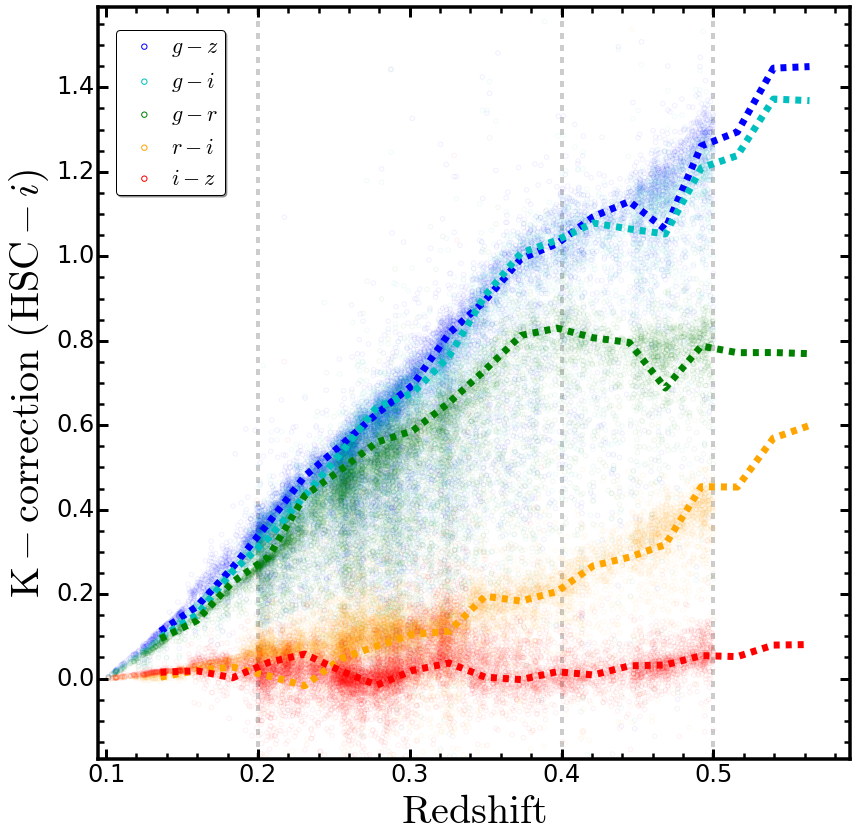

In [86]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.11, 0.11, 0.87, 0.87]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Luminosity bins
ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_G'] - gamaTab['KCORRECT_c_Z'], 
            marker='o', facecolor='none', edgecolor='b', s=20, 
            alpha=0.06, label='$g-z$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_G'] - gamaTab['KCORRECT_c_I'], 
            marker='o', facecolor='none', edgecolor='c', s=20, 
            alpha=0.06, label='$g-i$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_G'] - gamaTab['KCORRECT_c_R'], 
            marker='o', facecolor='none', edgecolor='g', s=20, 
            alpha=0.06, label='$g-r$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_R'] - gamaTab['KCORRECT_c_I'], 
            marker='o', facecolor='none', edgecolor='orange', s=20, 
            alpha=0.06, label='$r-i$')

ax1.scatter(gamaTab['Z'], gamaTab['KCORRECT_c_I'] - gamaTab['KCORRECT_c_Z'], 
            marker='o', facecolor='none', edgecolor='r', s=20, 
            alpha=0.06, label='$i-z$')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{HSC-}i)$', size=40)

# Axis limits
ax1.set_xlim(0.095, 0.59)
ax1.set_ylim(-0.19, 1.59)

ax1.legend(loc=(0.023, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_alpha(1.0)
legend.legendHandles[1].set_alpha(1.0)
legend.legendHandles[2].set_alpha(1.0)
legend.legendHandles[3].set_alpha(1.0)
legend.legendHandles[4].set_alpha(1.0)

## Running median 
XX = bcgTab['Z']
medBins = np.linspace(XX.min(), XX.max(), 20)
dltBins = (medBins[1] - medBins[0])
indBins = np.digitize(XX, medBins)
 
YY1 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_Z'])
medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

YY2 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_I'])
medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

YY3 = (bcgTab['KCORRECT_c_G'] - bcgTab['KCORRECT_c_R'])
medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

YY4 = (bcgTab['KCORRECT_c_R'] - bcgTab['KCORRECT_c_I'])
medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

YY5 = (bcgTab['KCORRECT_c_I'] - bcgTab['KCORRECT_c_Z'])
medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=7.0)
ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=7.0)

plt.show()
fig.savefig('../figure/hscMassive_z_kcorrect_color_gama.png', dpi=300)
